In [1]:
import h5py
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append('/home/amber/multitask_RNA/data_generation')
import utils
import numpy as np

In [2]:
file = h5py.File("/home/amber/multitask_RNA/data/CAGI/CAGI_onehot.h5", "r")
alt = file['alt']
ref = file['ref']

## Nucleotide Transformer zero shot test

cosine similarity between embeddings with different alleleß

In [3]:
import nucleotide_transformer
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model
from tqdm import tqdm
model_name = '500M_1000G'

In [4]:
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=(24,),
    attention_maps_to_save=(),
    max_positions=513,
)
forward_fn = hk.transform(forward_fn)

In [5]:
random_key = jax.random.PRNGKey(0)
N, L, A = alt.shape
mut_i = int(L/2-1)
cagi_llr=[]
for i in tqdm(range(N)):
    seq = utils.onehot_to_seq([ref[i],alt[i]])
    token_out = tokenizer.batch_tokenize(seq)
    token_id = [b[1] for b in token_out]
    seq_pair = jnp.asarray(token_id,dtype=jnp.int32)
    outs = forward_fn.apply(parameters, random_key, seq_pair)
    ref_seq = outs['embeddings_24'][0]
    alt_seq = outs['embeddings_24'][1]
    #cosine similarity
    cagi_llr.append((ref_seq * alt_seq).sum()/(jnp.linalg.norm(ref_seq)*jnp.linalg.norm(alt_seq)))
    if i == 4:
        break


  0%|          | 4/18442 [00:08<10:52:03,  2.12s/it]


In [20]:
(ref_seq * alt_seq).sum()/(jnp.linalg.norm(ref_seq)*jnp.linalg.norm(alt_seq))

Array(0.999932, dtype=float32)

In [21]:
cagi_llr

[Array(0.99993193, dtype=float32),
 Array(0.9999533, dtype=float32),
 Array(0.999915, dtype=float32),
 Array(0.9998209, dtype=float32),
 Array(0.999932, dtype=float32)]

In [7]:
output = h5py.File('./cagi_nuc_trans.h5', 'w')
output.create_dataset('llr', data=np.array(cagi_llr))
output.close()

## Visulization

In [2]:
import h5py
import pandas as pd
import numpy as np
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats
cagi_result = h5py.File('./cagi_nuc_trans.h5', 'r')
llr = cagi_result['llr'][()]

In [3]:
cagi_df = pd.read_csv('../../data/CAGI/final_cagi_metadata.csv',
                      index_col=0).reset_index()
exp_list = cagi_df['8'].unique()
plot_figure=True

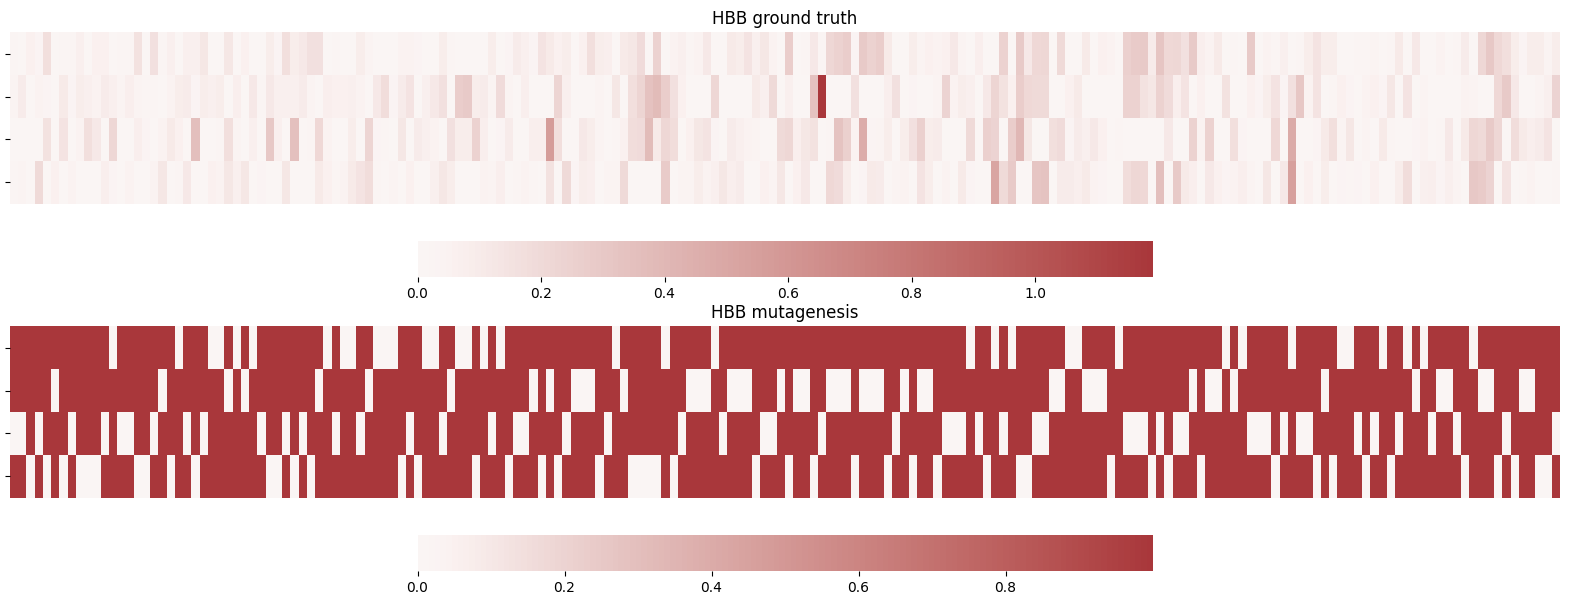

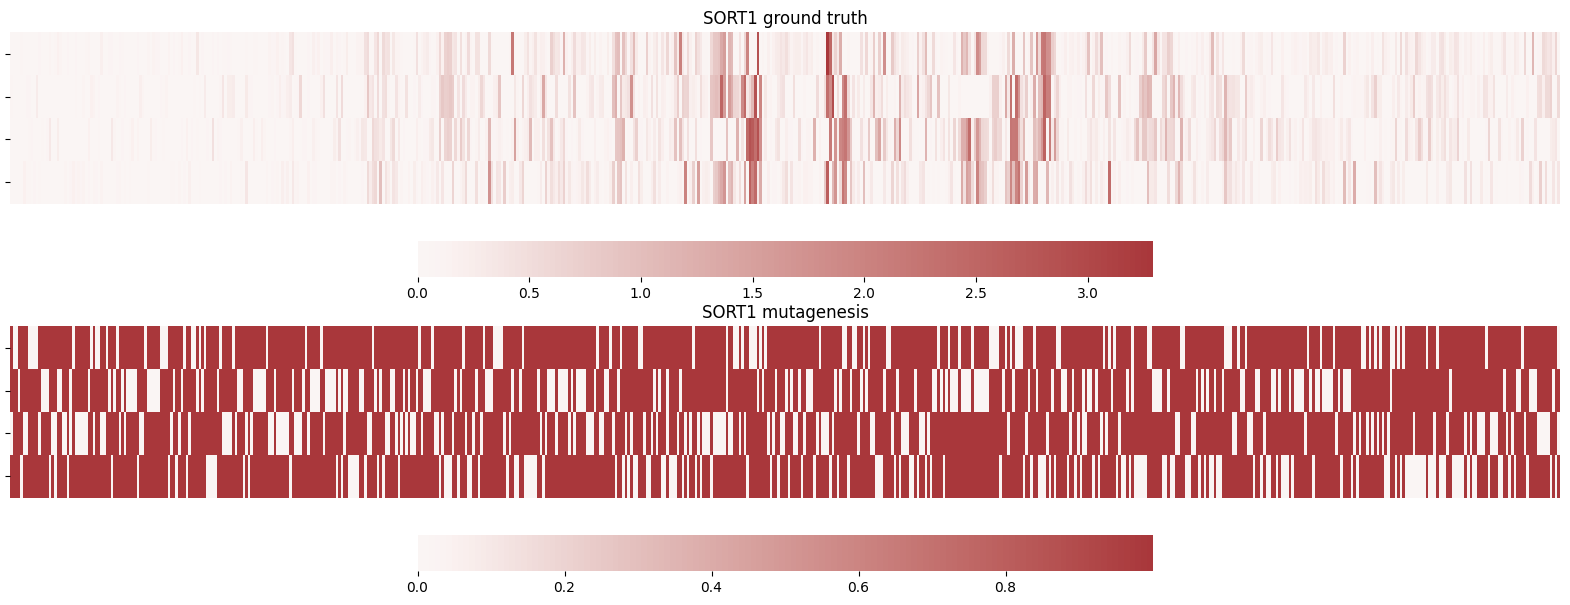

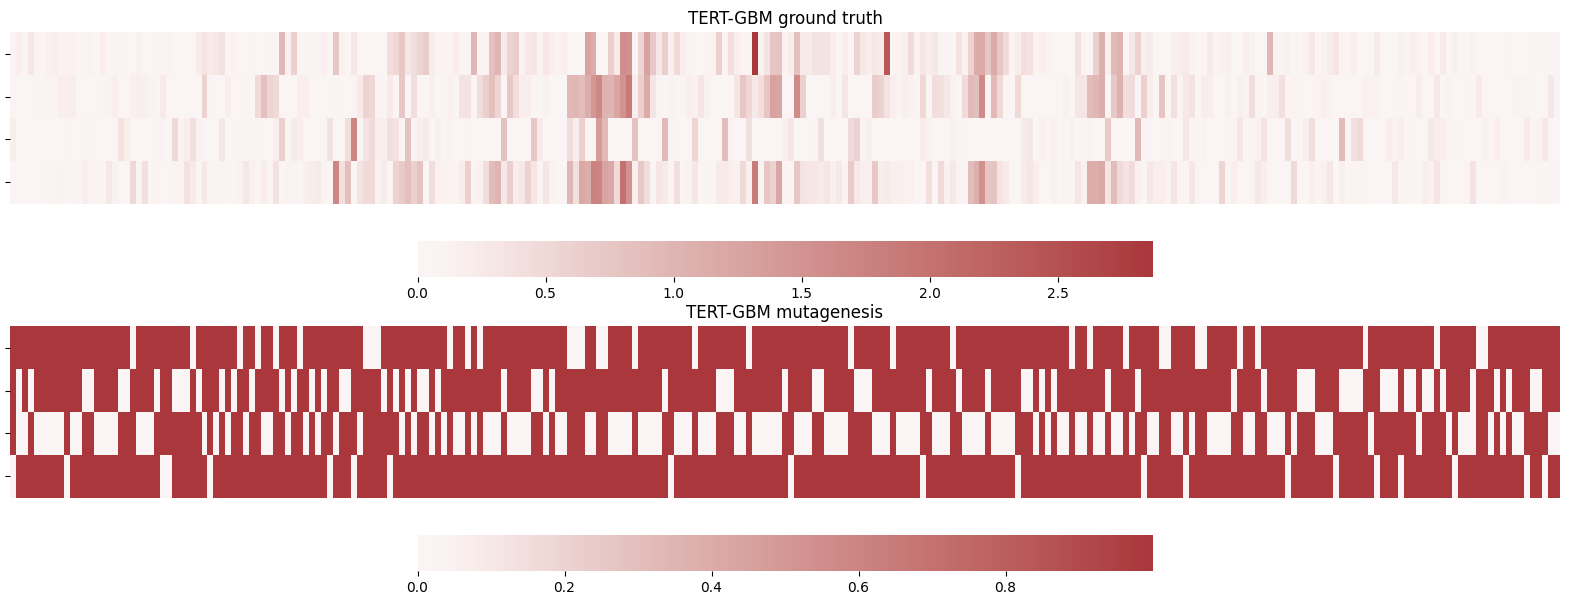

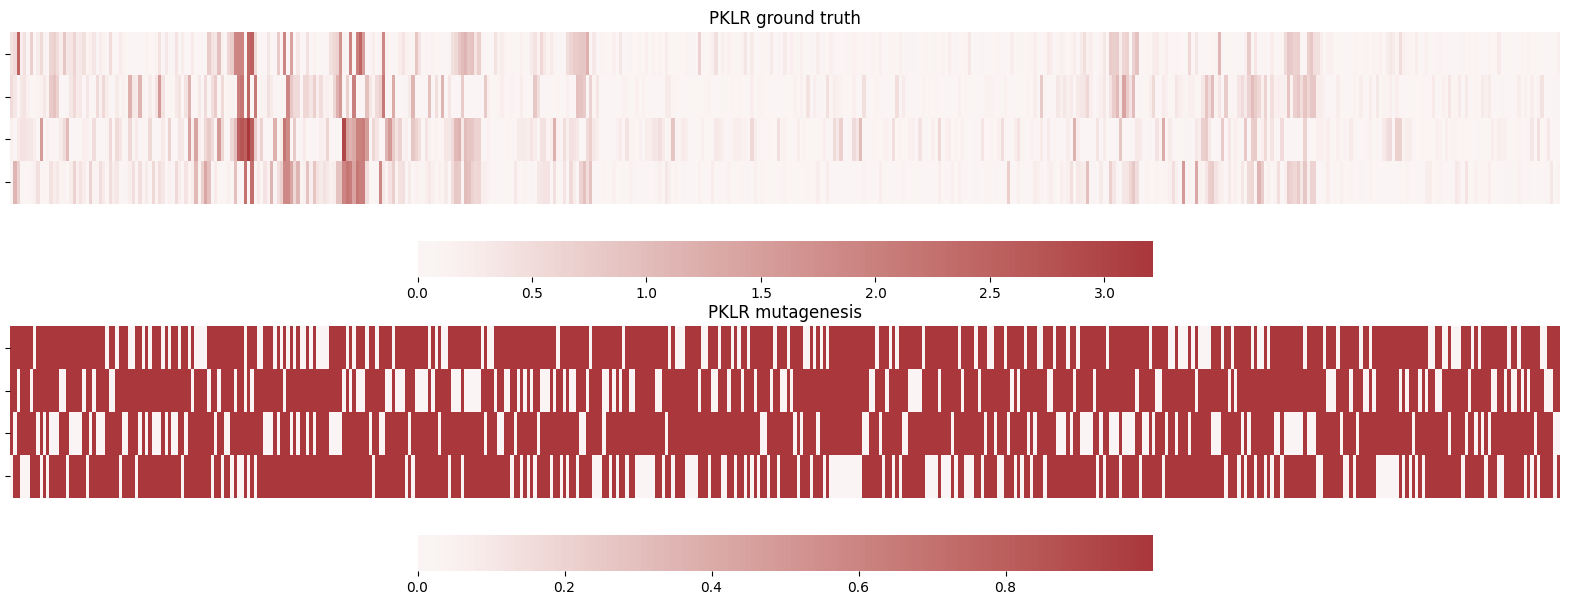

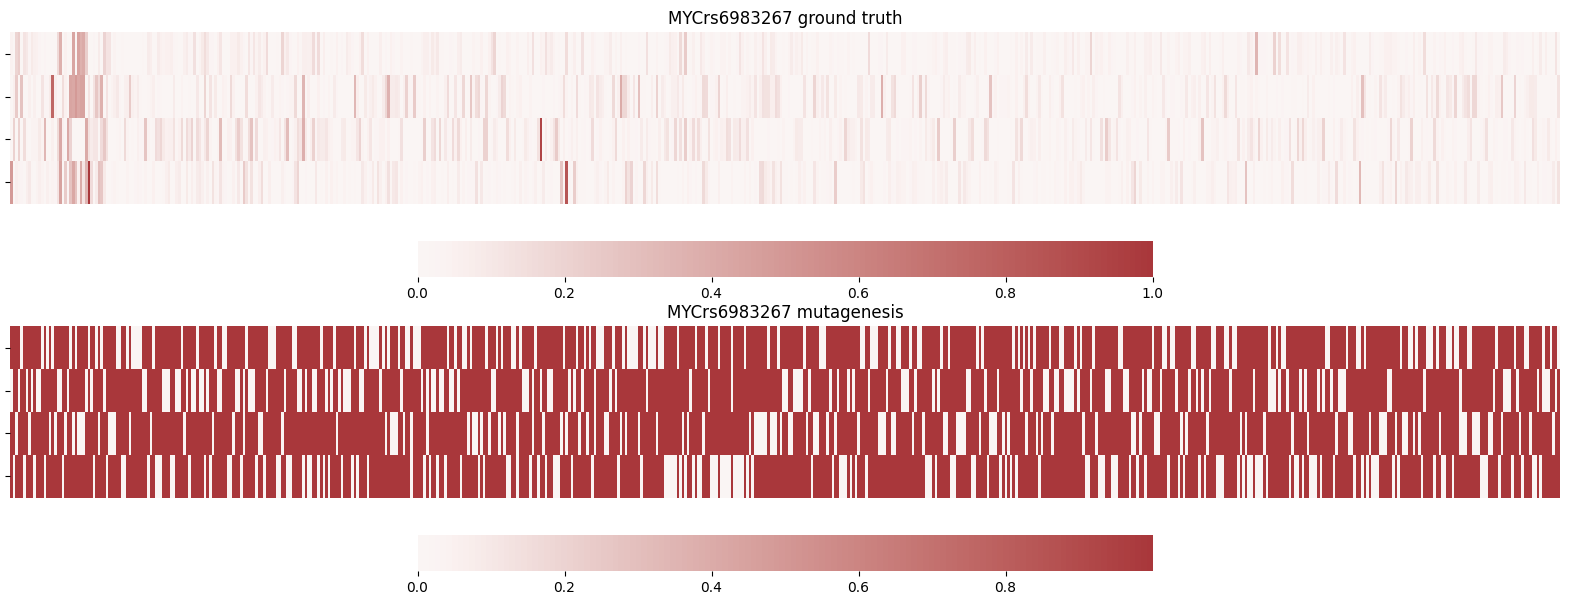

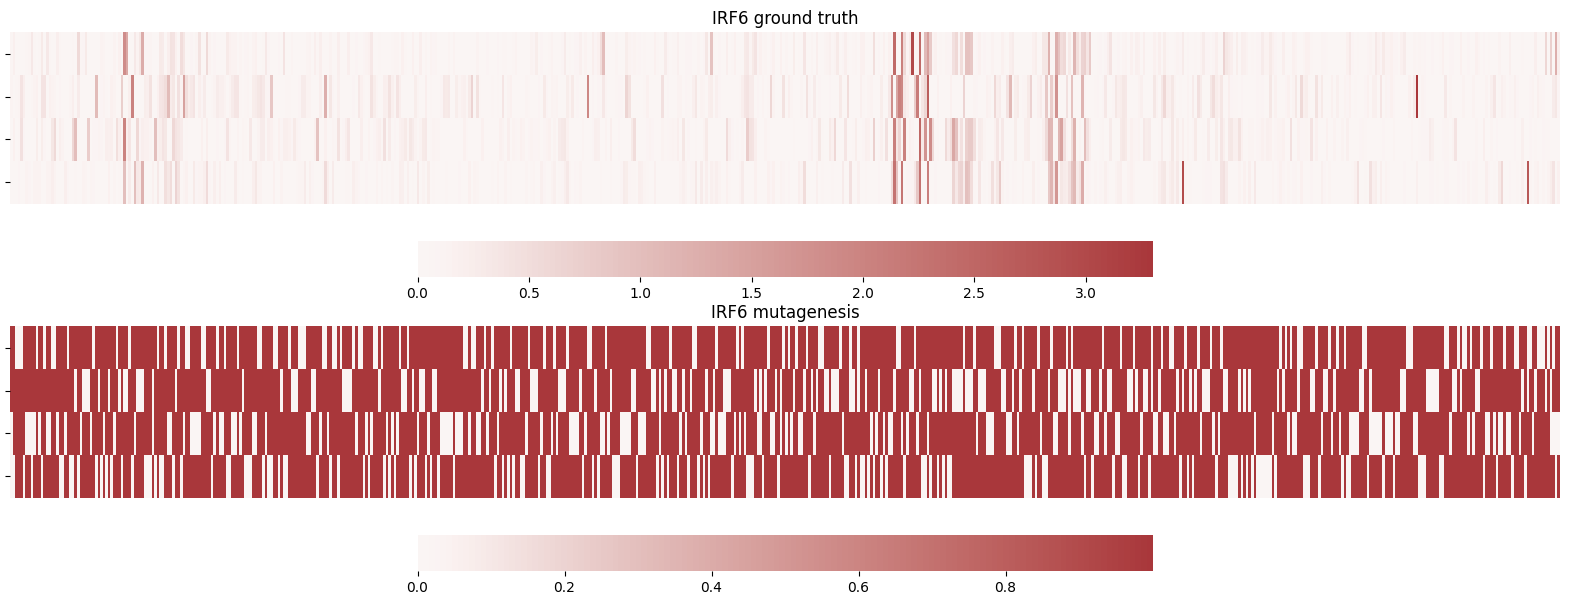

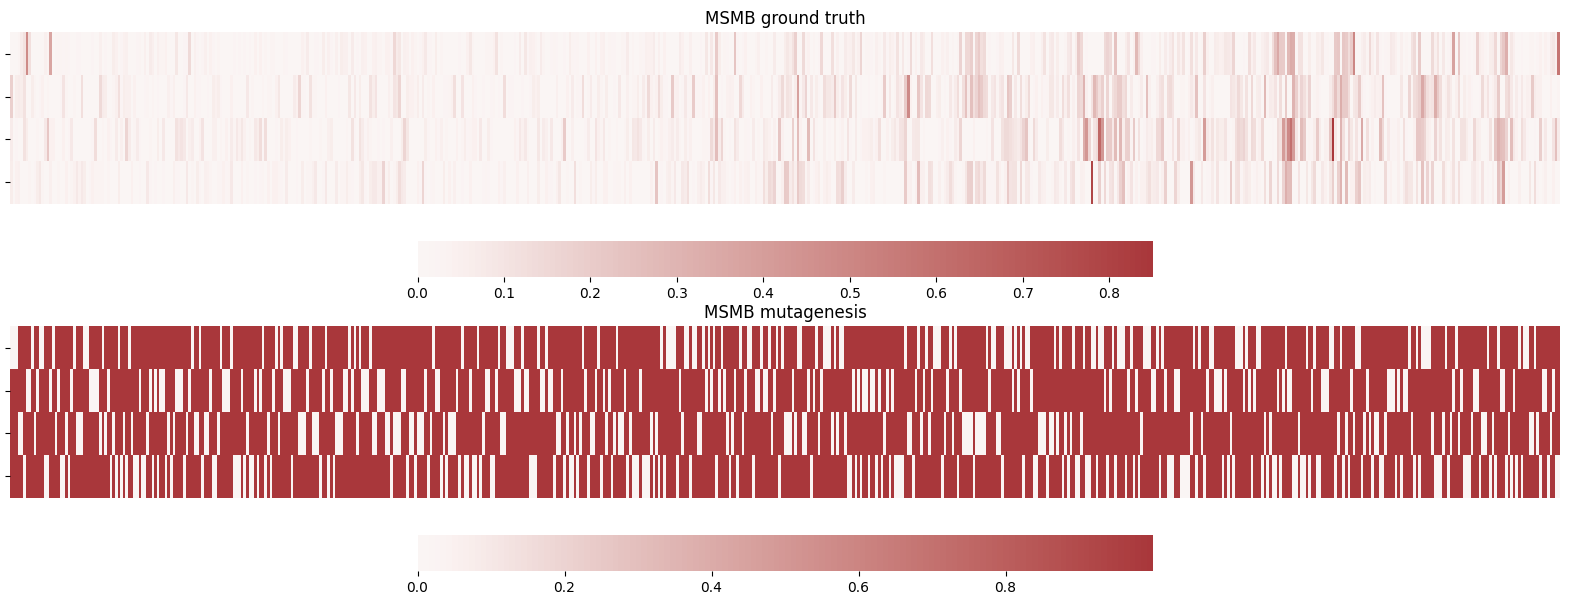

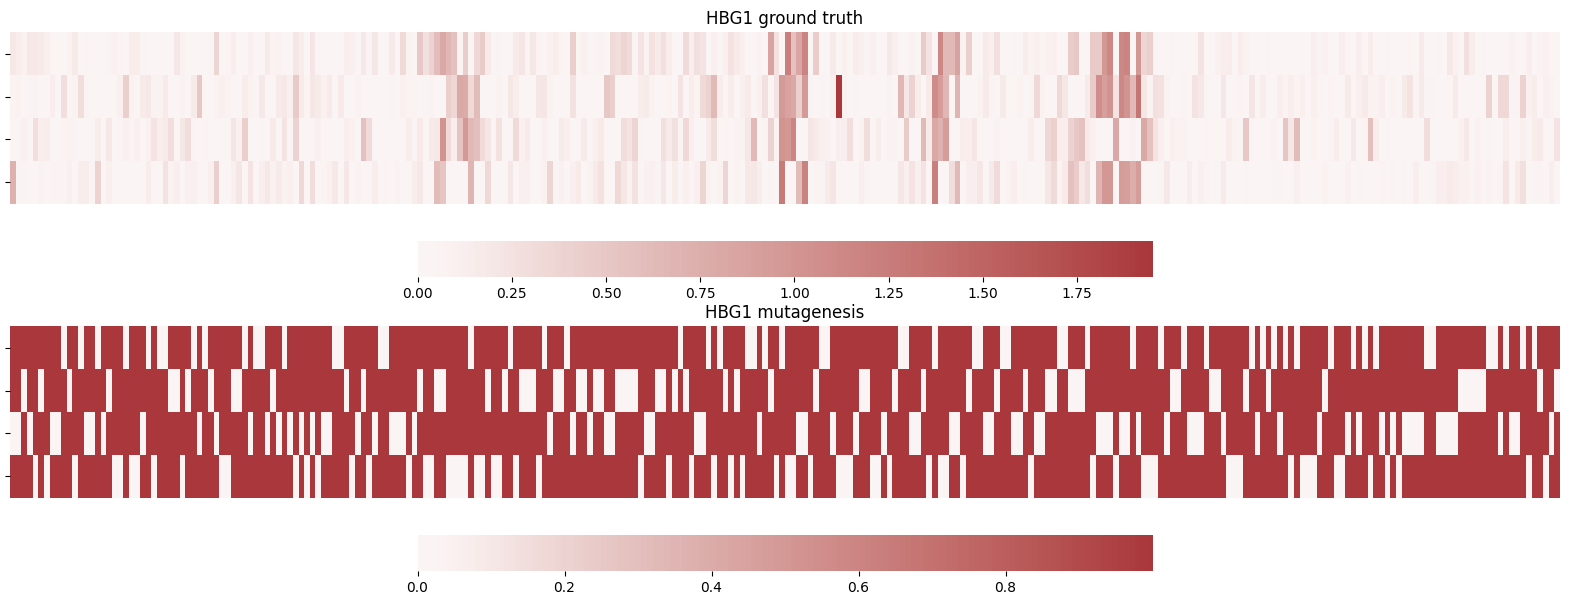

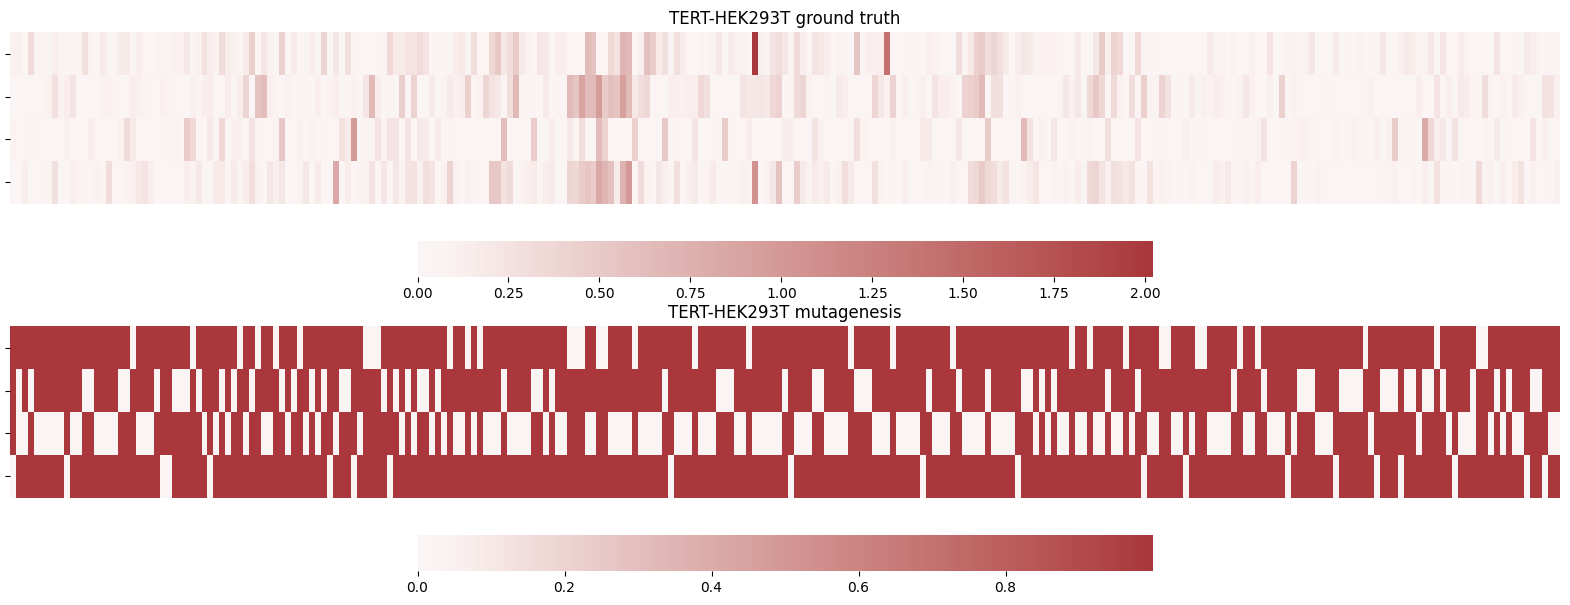

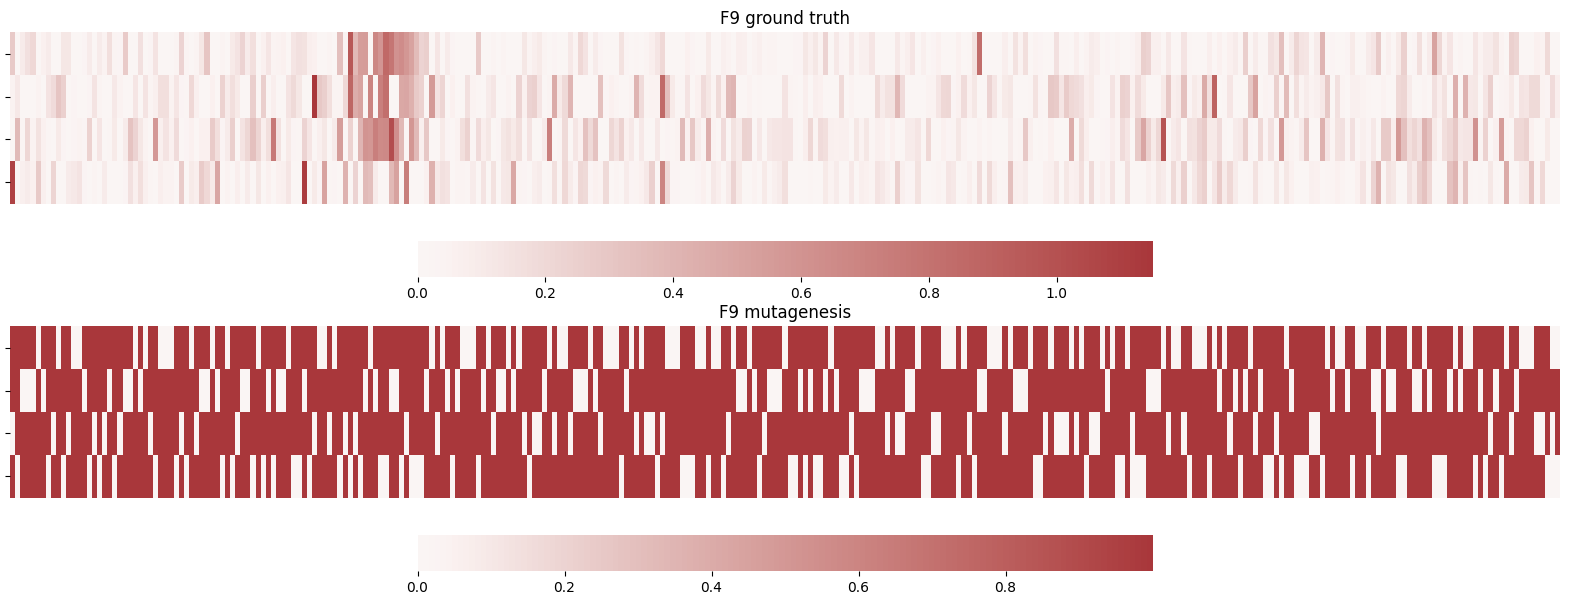

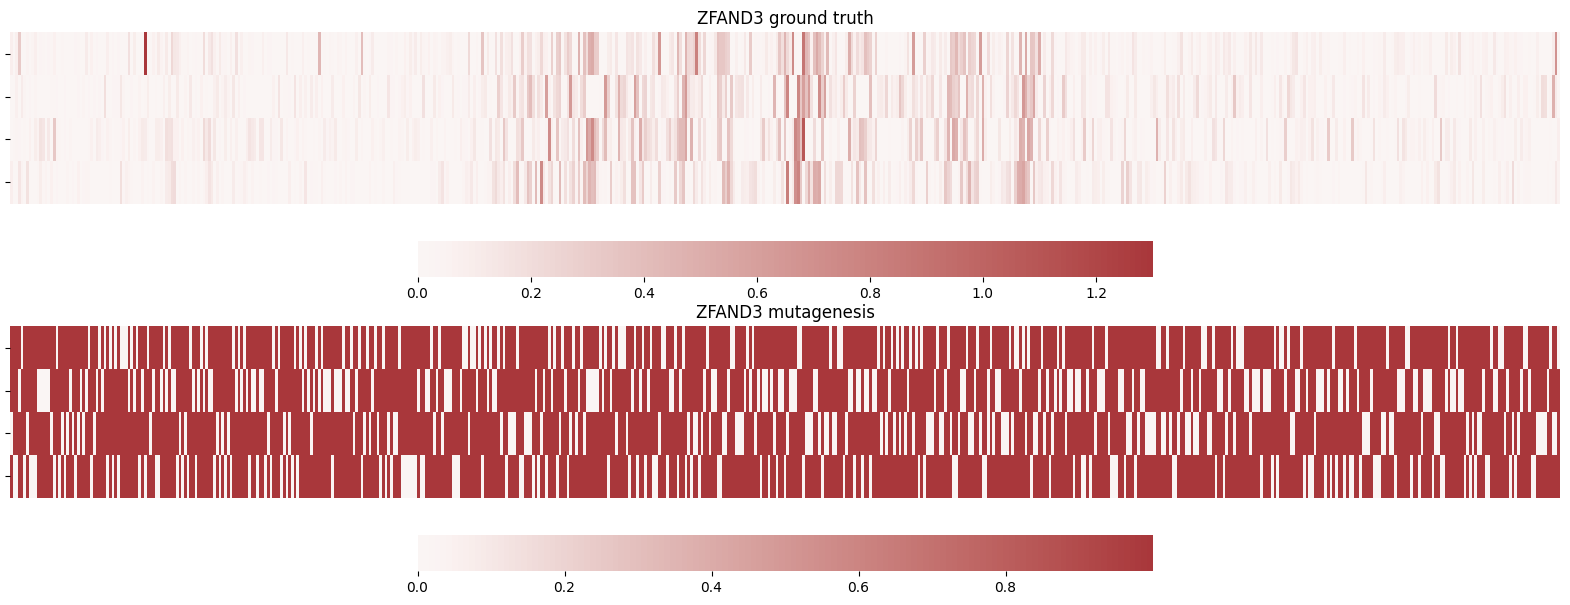

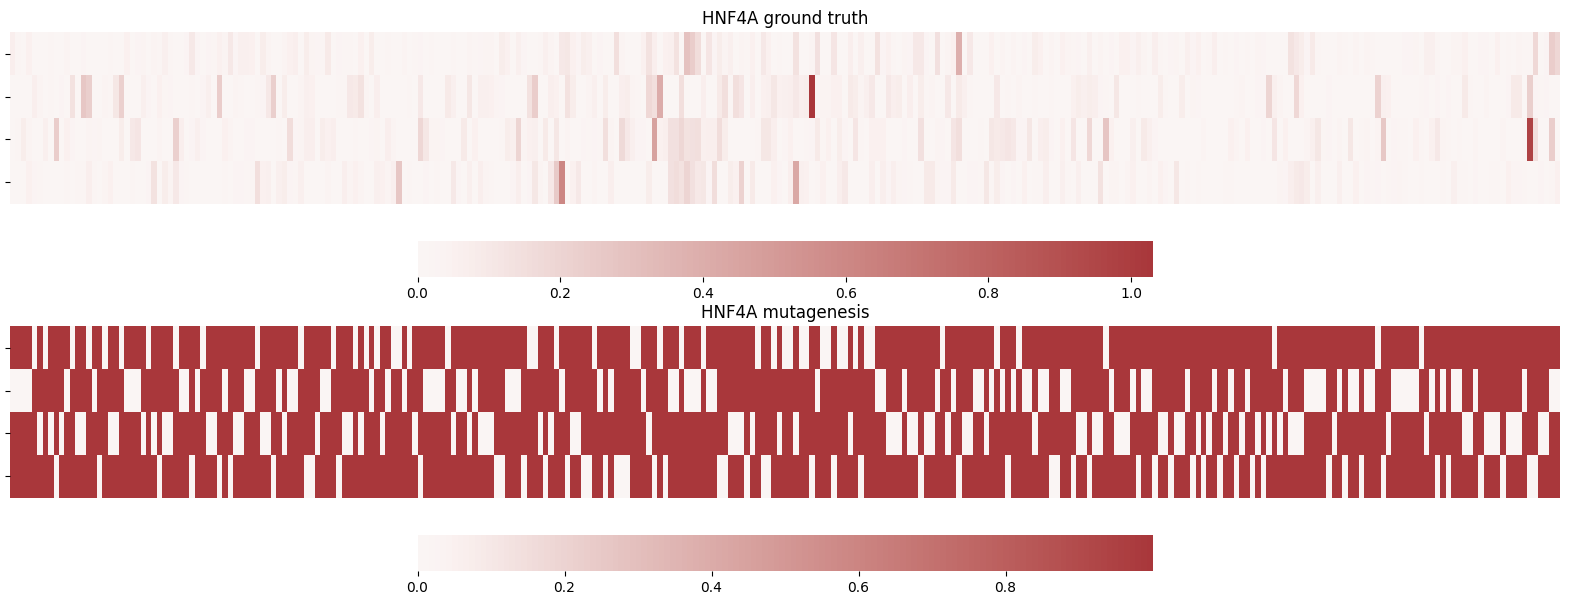

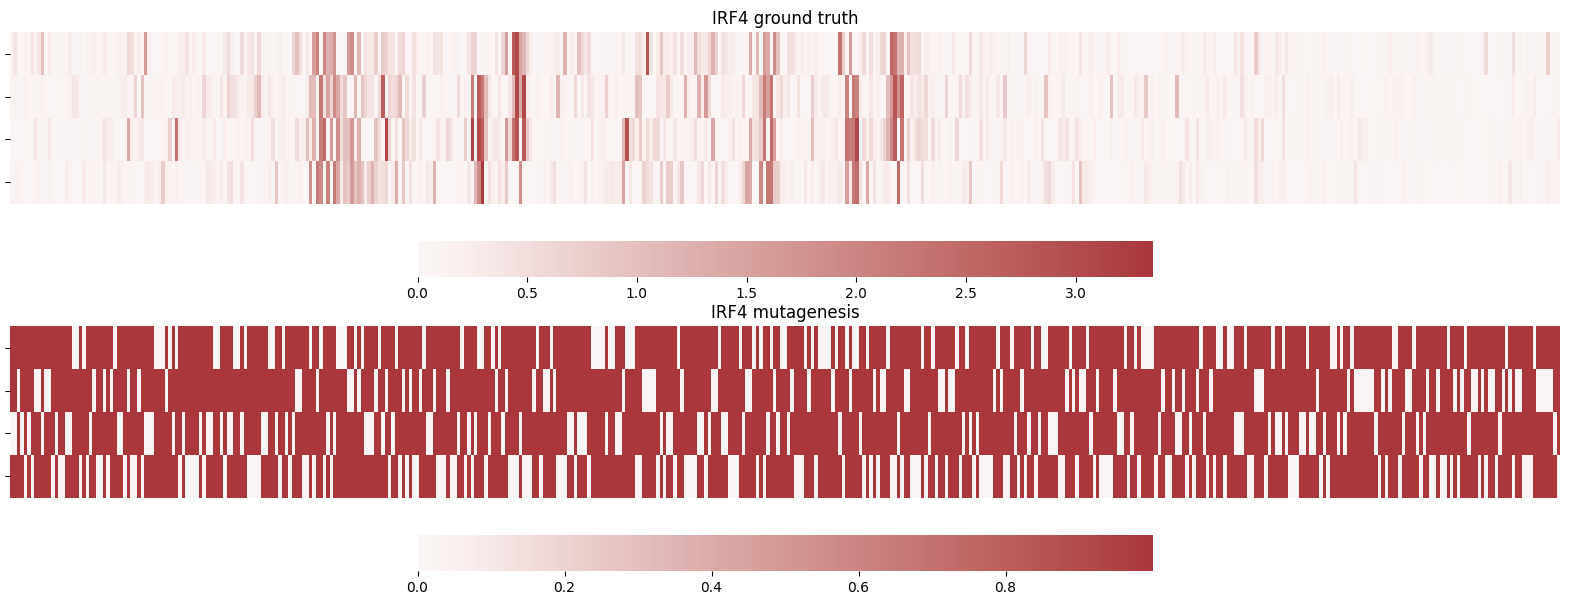

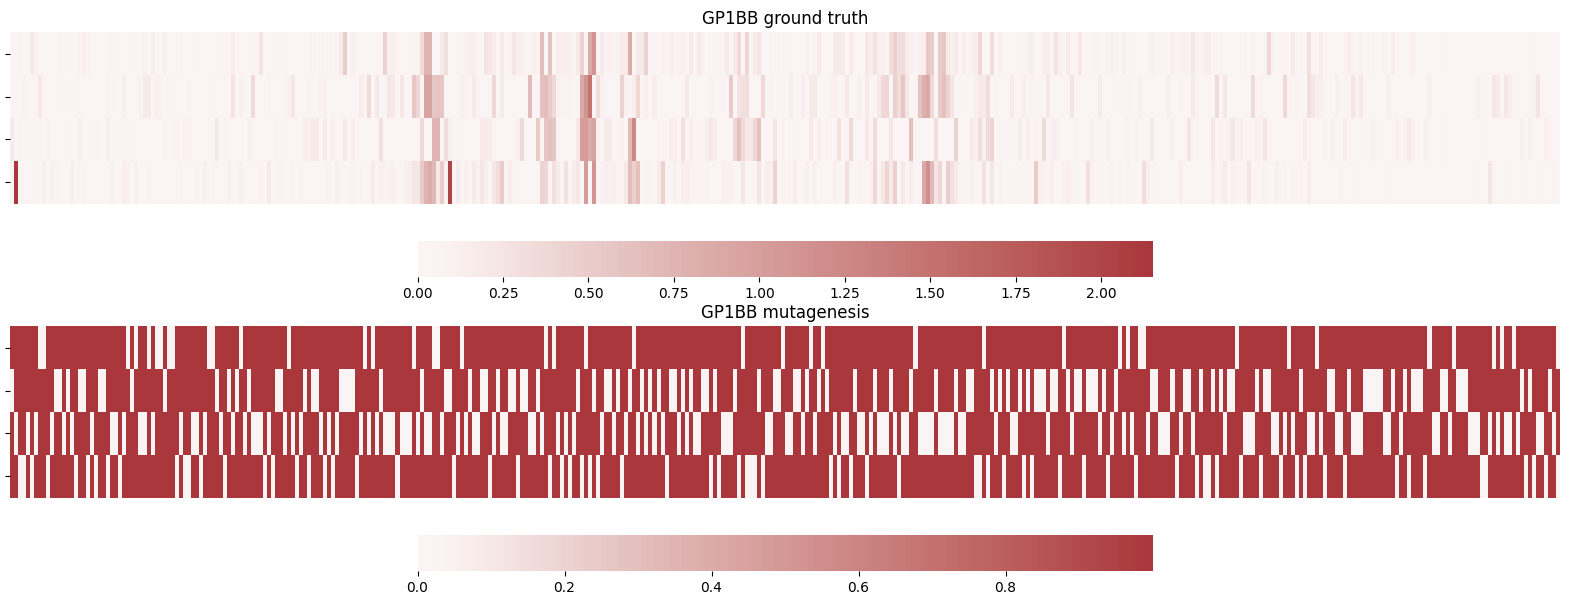

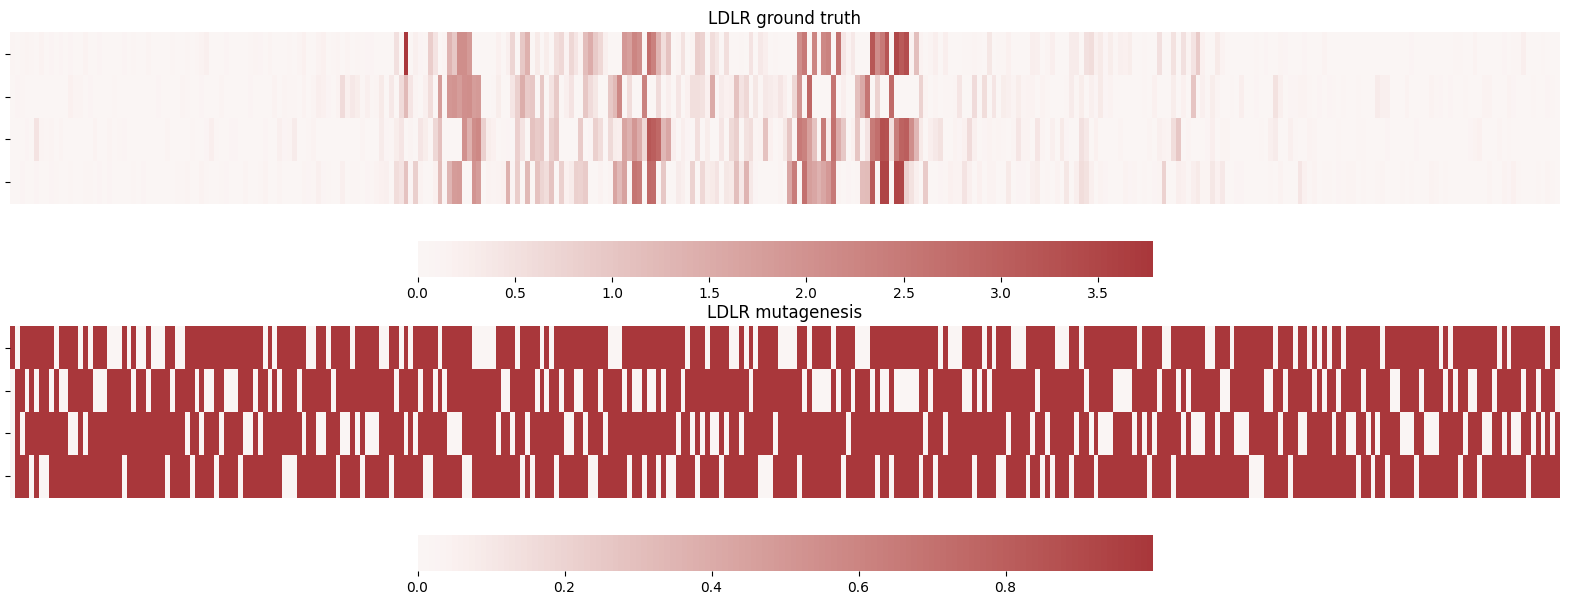

In [8]:
performance_dict = {}
idx = {'A':0,'C':1,'G':2,'T':3}
for exp in exp_list:
    exp_df = cagi_df[cagi_df['8']==exp]
    idx_df = exp_df[['0','1','2']].drop_duplicates().sort_values(by=['1'])
    exp_len = len(exp_df['1'].unique())
    effect_size = np.zeros((4,exp_len))
    predict_size = np.zeros((4,exp_len))
    
    for pos in range(0,exp_len):
        row = idx_df.iloc[pos]
        loci_df = exp_df[(exp_df['0']==row['0'])&(exp_df['1']==row['1'])&(exp_df['2']==row['2'])]
        loci_idx = loci_df.index
        ref_allele = loci_df['3'].drop_duplicates().values
        alt_allele = loci_df['4'].values.tolist()
        diff = loci_df['6'].values

        effect_size[itemgetter(*alt_allele)(idx),pos] =np.absolute(diff)
        predict_size [itemgetter(*alt_allele)(idx),pos] =llr[loci_idx]
    r_value = stats.pearsonr(effect_size.flatten(),predict_size.flatten())
    performance_dict[exp]= r_value[0]
    if plot_figure:
        fig,ax = plt.subplots(2,1,figsize = (20,7))
        #fig2=plt.figure(figsize = (20,2))
        fig1 = sns.heatmap(effect_size,cmap = 'vlag',
                            center = 0,
                            #annot = exp_annot,fmt = '',
                        cbar_kws = dict(use_gridspec=False,location="bottom"),
                        ax = ax[0]);
        ax[0].tick_params(left=True, bottom=False);
        #ax.set_yticklabels(['A','C','G','T'],size = 1);
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([]);
        ax[0].set_title(exp+' ground truth')
        #plt.tight_layout()

        #fig3=plt.figure(figsize = (20,2))
        fig2 = sns.heatmap(predict_size,cmap = 'vlag',
                            center = 0,
                            #annot = pred_annot,fmt = '',
                            cbar_kws = dict(use_gridspec=False,location="bottom"),
                            ax = ax[1]);
        ax[1].tick_params(left=True, bottom=False);
        #ax.set_yticklabels(['A','C','G','T'],size = 1);
        ax[1].set_yticklabels([])
        ax[1].set_xticklabels([])
        ax[1].set_title(exp+' mutagenesis')

In [9]:
performance_dict

{'HBB': 0.4576288225262134,
 'SORT1': 0.34576196792449126,
 'TERT-GBM': 0.3852915649638305,
 'PKLR': 0.35361131272407864,
 'MYCrs6983267': 0.3637724659160702,
 'IRF6': 0.29611095274909643,
 'MSMB': 0.3939580450505349,
 'HBG1': 0.3649181731287204,
 'TERT-HEK293T': 0.408268119641655,
 'F9': 0.4061355435034613,
 'ZFAND3': 0.37961043913449616,
 'HNF4A': 0.33818932408059305,
 'IRF4': 0.3154127990713238,
 'GP1BB': 0.3248416267325858,
 'LDLR': 0.2867984790769957}

In [24]:
np.array(list(performance_dict.values())).mean()

0.3613539757482765